# 3 - Evaluation for the different models

All the import needed

In [ ]:
import numpy as np 
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.models import load_model

## I - Downloading of the model 

Lets download the prediction from the persistence model and evaluate it to have a baseline 

In [ ]:
Y_pred = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_pred.npy')
Y_true = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_true.npy')

## II - Choice of metrics 

Here the goal is to predict an image from an image, therefore we want to compare images on a pixel to pixel base. As we are not doing an advanced research project we can maybe for now stay with some common metrics such as MAE:

$$
\mathrm{MAE} = \frac{1}{N} \sum_{i=1}^{N} \left| \hat{y}_i - y_i \right|
$$

Which will allow us to have an idea of the mean error across an image.
Another metric we can use, that is commonly used in analysis of meteorological images is RMSE which will give us a closer insight about the 'bigger' errors. 

$$
\mathrm{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \hat{y}_i - y_i \right)^2 }
$$

## III - Evaluation of the persistence model

In [ ]:
start_time = time.time()

mae = mean_absolute_error(Y_true.flatten(), Y_pred.flatten())
rmse = mean_squared_error(Y_true.flatten(), Y_pred.flatten())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Running time : {elapsed_time:.4f} s")

MAE : 0.0147
RMSE : 0.0004
Running time : 0.0129 s


In [ ]:
error_map = np.abs(Y_true[0] - Y_pred[0])
print("Min erreur absolue :", error_map.min())
print("Max erreur absolue :", error_map.max())


Min erreur absolue : 0.0
Max erreur absolue : 0.09924972


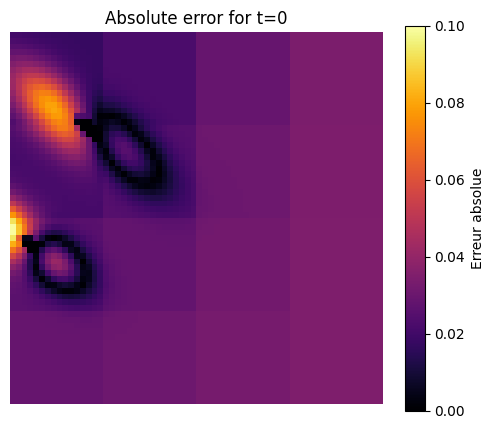

In [23]:
plt.figure(figsize=(6, 5))
plt.imshow(error_map, cmap='inferno',vmin=0, vmax=0.1)
plt.title("Absolute error for t=0")
plt.colorbar(label="Erreur absolue")
plt.axis("off")
plt.show()

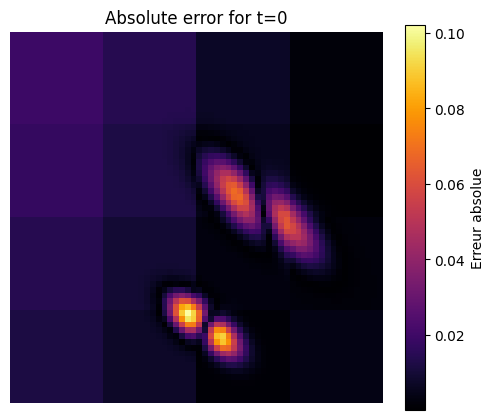

In [ ]:
error_map = np.abs(Y_true[48] - Y_pred[48])

plt.figure(figsize=(6, 5))
plt.imshow(error_map, cmap='inferno')
plt.title("Absolute error for t=48")
plt.colorbar(label="Erreur absolue")
plt.axis("off")
plt.show()

As we only have a few precipitations over the whole image, the persistence model is able to get quite 'good' acuracy by just predicting the same or nearly the same as t=i for t=i+1 and adjusting a little bit for t=i+2. 

The goal is now to compare to the performance of a more complex model. 

## IV - Evaluation of the Unet 

In [ ]:
X = np.load("path/X_unet.npy")
Y = np.load("path/Y_unet.npy")


model = tf.keras.models.load_model(
    "path/Unet_simple.h5",
    compile=False
)


history = np.load(
    "path/Unet_simple_history.npy",
    allow_pickle=True
).item()

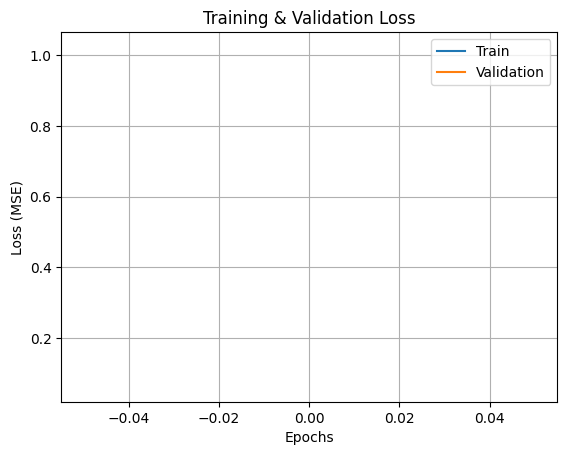

In [28]:
plt.plot(history['loss'], label="Train")
plt.plot(history['val_loss'], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


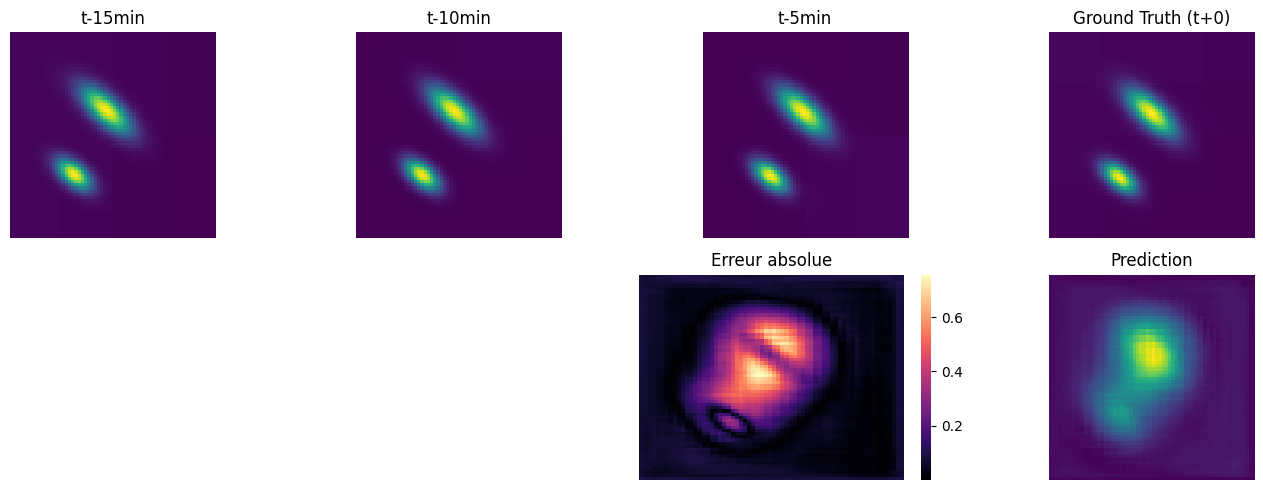

In [33]:

i = 0  #test index
pred = model.predict(X_val[i:i+1])[0, ..., 0]
truth = Y_val[i, ..., 0]
input_frames = X_val[i]

error_map = np.abs(pred - truth)

plt.figure(figsize=(14, 5))

# Entrée : les 3 images du passé
for j in range(3):
    plt.subplot(2, 4, j+1)
    plt.imshow(input_frames[..., j], cmap='viridis')
    plt.title(f"t-{15 - j*5}min")
    plt.axis('off')

# Vérité terrain
plt.subplot(2, 4, 4)
plt.imshow(truth, cmap='viridis')
plt.title("Ground Truth (t+0)")
plt.axis('off')

# Prédiction
plt.subplot(2, 4, 8)
plt.imshow(pred, cmap='viridis')
plt.title("Prediction")
plt.axis('off')

# Heatmap de l'erreur
plt.subplot(2, 4, 7)
sns.heatmap(error_map, cmap='magma', cbar=True)
plt.title("Erreur absolue")
plt.axis('off')

plt.tight_layout()
plt.show()


## V - Evaluation of UnetSAO model 

2025-06-27 13:37:09.468017: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 13:37:09.536084: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 13:37:09.602086: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 836.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


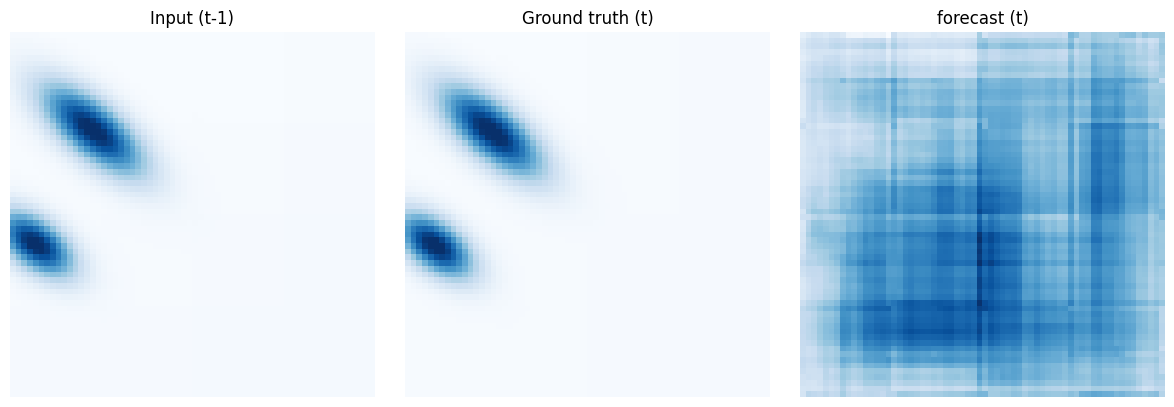

In [ ]:
model = load_model('path/unet_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


X_unet = np.load('path/X_unet.npy')
Y_unet = np.load('path/Y_unet.npy')


idx = 0  
x_sample = X_unet[idx:idx+1]  # (1, h, w, t)
y_true = Y_unet[idx]          # (h, w, 1)
y_pred = model.predict(x_sample)[0]  # (h, w, 1)


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

#last input given to it
axs[0].imshow(x_sample[0, :, :, -1], cmap='Blues')
axs[0].set_title("Input (t-1)")
axs[0].axis('off')

axs[1].imshow(y_true[:, :, 0], cmap='Blues')
axs[1].set_title("Ground truth (t)")
axs[1].axis('off')

axs[2].imshow(y_pred[:, :, 0], cmap='Blues')
axs[2].set_title("forecast (t)")
axs[2].axis('off')

plt.tight_layout()
plt.show()  

It appears the model has learn to make a uniform prediction to minimise the loss without approching a true reflectivity image. We may be able to change that using a different loss. 